Memuat model YOLO. Mohon tunggu...
Model berhasil dimuat.

Processing split: VALID


Processing valid:   0%|          | 0/173 [00:00<?, ?it/s]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/healthy_train_69_jpg.rf.84dbba6fd690afe7be3d5e5cf295cad2.jpg: 448x640 2 leaf_healthys, 45.7ms
Speed: 1.5ms preprocess, 45.7ms inference, 201.9ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   1%|          | 1/173 [00:03<08:53,  3.10s/it]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/healthy_train_213_jpg.rf.0628f91eef0d602d2c8a4ba416579aa1.jpg: 448x640 3 leaf_healthys, 14.4ms
Speed: 1.7ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   1%|          | 2/173 [00:03<05:01,  1.77s/it]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/healthy_train_380_jpg.rf.f2b3e90f6bb623f366de2ff8526b6eae.jpg: 448x640 3 leaf_healthys, 12.6ms
Speed: 1.6ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   2%|▏         | 3/173 [00:04<03:49,  1.35s/it]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/rust_train_148_jpg.rf.7035f9ea270adc22d7eab330bffcf998.jpg: 448x640 1 leaf_rust, 13.5ms
Speed: 1.7ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   2%|▏         | 4/173 [00:05<03:14,  1.15s/it]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/rust_train_525_jpg.rf.0a2b4ae4e32ac8bc6558074f2abda1b7.jpg: 448x640 2 leaf_rusts, 14.2ms
Speed: 1.5ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   3%|▎         | 5/173 [00:06<02:55,  1.04s/it]


image 1/1 /home/nugee/Abiya/TelU-Tubes-Thesis-PlantDiseaseSeverity/utils/../dataset/mask_daun/valid/images/scab_train_344_jpg.rf.1525b7bfce4f0b4133cd968902960394.jpg: 448x640 1 leaf_scab, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing valid:   3%|▎         | 5/173 [00:06<03:43,  1.33s/it]


KeyboardInterrupt: 

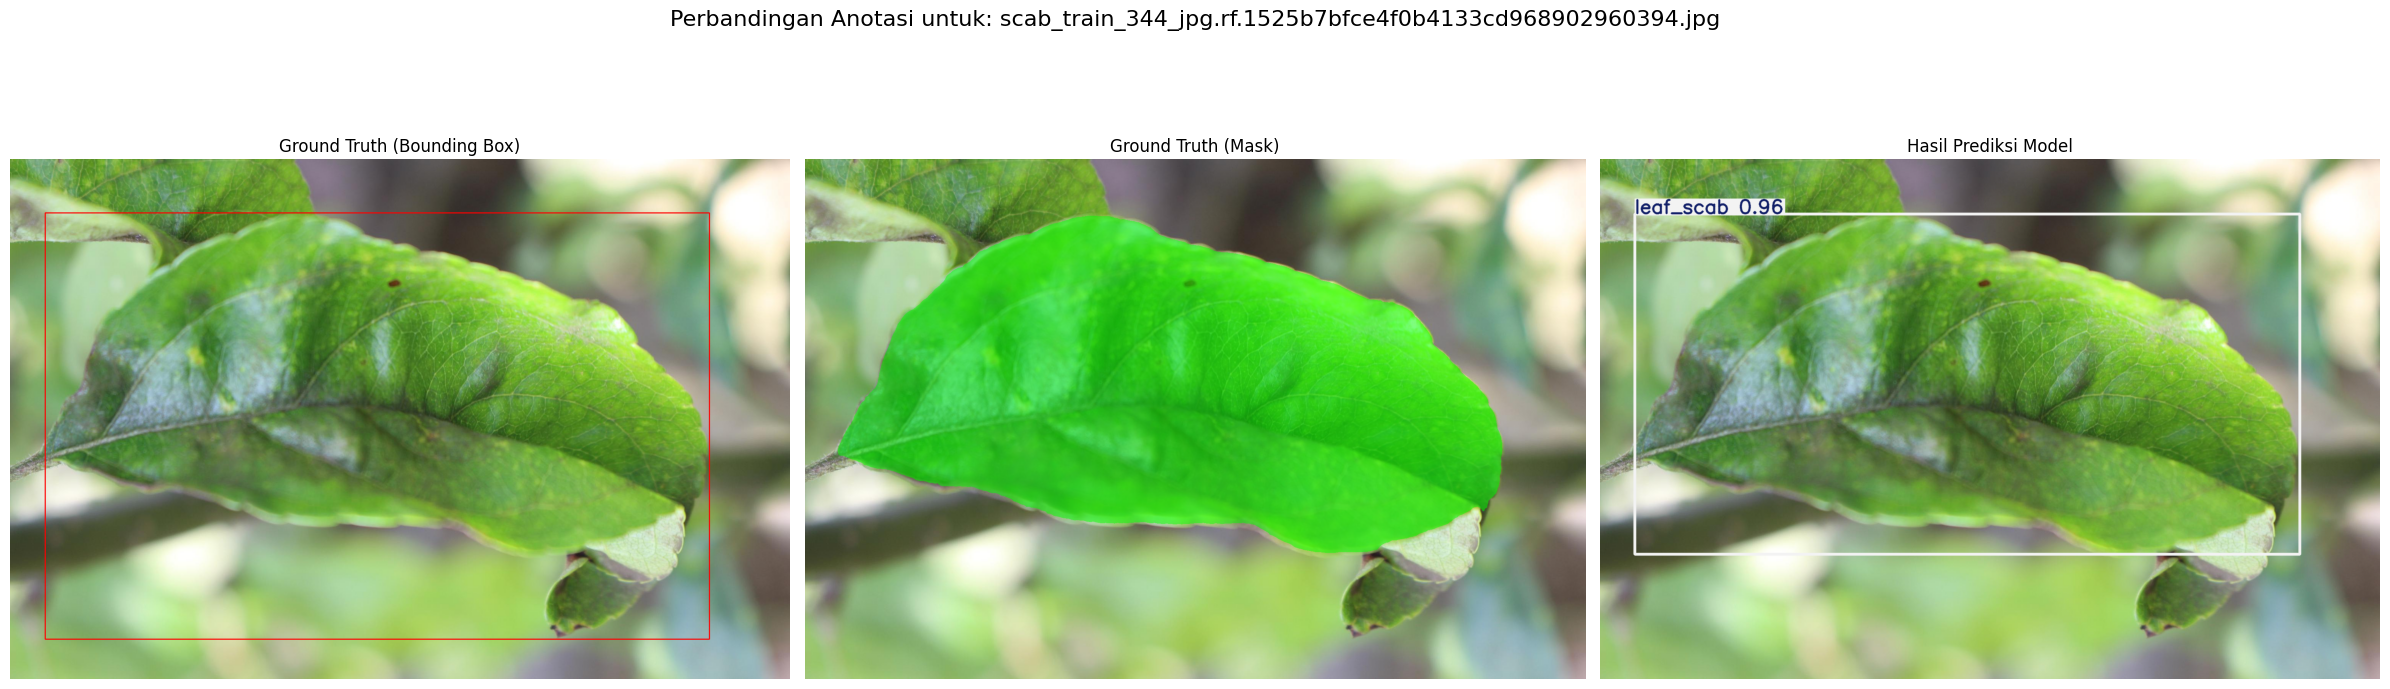

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm

def process_and_visualize_split(split_name, base_dataset_dir, model, base_output_dir):
    """
    Memproses semua gambar dalam satu set data (train, val, atau test)
    dan menyimpan visualisasi perbandingannya. Jika visualisasi sudah ada,
    proses akan dilewati.

    Args:
        split_name (str): Nama set data ('train', 'val', 'test').
        base_dataset_dir (Path): Path objek ke direktori dasar dataset.
        model (YOLO): Objek model YOLO yang sudah dimuat.
        base_output_dir (Path): Path objek ke direktori dasar output.
    """
    print(f"\n{'='*25}\nProcessing split: {split_name.upper()}\n{'='*25}")

    # 1. Definisikan semua path yang relevan untuk split ini
    image_dir = base_dataset_dir / 'mask_daun' / split_name / 'images'
    mask_label_dir = base_dataset_dir / 'mask_daun' / split_name / 'labels'
    bbox_label_dir = base_dataset_dir / 'object_detection' / split_name / 'labels'
    output_dir = base_output_dir / split_name

    output_dir.mkdir(parents=True, exist_ok=True)

    image_files = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.jpeg')) + list(image_dir.glob('*.png'))

    if not image_files:
        print(f"⚠️  Peringatan: Tidak ada gambar ditemukan di {image_dir}, melewati split ini.")
        return

    # 2. Loop melalui setiap gambar dalam direktori dengan progress bar
    for image_path in tqdm(image_files, desc=f"Processing {split_name}"):
        base_name = image_path.stem
        
        # --- MODIFIKASI DIMULAI DI SINI ---
        
        # Tentukan path output terlebih dahulu
        output_filename = f"komparasi_{base_name}.png"
        output_path = output_dir / output_filename

        # Jika file output sudah ada, lewati (skip) proses untuk gambar ini
        if output_path.exists():
            continue # Lanjut ke file berikutnya di dalam loop

        # --- AKHIR MODIFIKASI ---

        image = cv2.imread(str(image_path))
        if image is None:
            tqdm.write(f"❌ Gagal membaca {image_path.name}, dilewati.")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        
        image_with_bbox = image_rgb.copy()
        image_for_mask = image_rgb.copy()

        # 3. Gambar Ground Truth Bounding Box
        bbox_label_path = bbox_label_dir / f"{base_name}.txt"
        if bbox_label_path.exists():
            with open(bbox_label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    _, x_c, y_c, w_norm, h_norm = map(float, parts)
                    x1, y1 = int((x_c - w_norm / 2) * w), int((y_c - h_norm / 2) * h)
                    x2, y2 = int((x_c + w_norm / 2) * w), int((y_c + h_norm / 2) * h)
                    cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        
        # 4. Gambar Ground Truth Mask
        mask_label_path = mask_label_dir / f"{base_name}.txt"
        if mask_label_path.exists():
            mask_overlay = image_for_mask.copy()
            with open(mask_label_path, 'r') as f:
                for line in f:
                    polygon_norm = np.array(line.strip().split()[1:], dtype=np.float32).reshape(-1, 2)
                    polygon_pixels = (polygon_norm * np.array([w, h])).astype(np.int32)
                    cv2.fillPoly(mask_overlay, [polygon_pixels], color=(0, 255, 0))
            image_with_mask = cv2.addWeighted(mask_overlay, 0.5, image_for_mask, 0.5, 0)
        else:
            image_with_mask = image_for_mask

        # 5. Lakukan Prediksi dengan Model (hanya jika file output belum ada)
        results = model.predict(source=str(image_path))
        predicted_image_bgr = results[0].plot()
        predicted_image_rgb = cv2.cvtColor(predicted_image_bgr, cv2.COLOR_BGR2RGB)

        # 6. Buat dan simpan plot 3 panel
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        fig.suptitle(f"Perbandingan Anotasi untuk: {image_path.name}", fontsize=16)

        axes[0].imshow(image_with_bbox)
        axes[0].set_title("Ground Truth (Bounding Box)")
        axes[0].axis('off')

        axes[1].imshow(image_with_mask)
        axes[1].set_title("Ground Truth (Mask)")
        axes[1].axis('off')
        
        axes[2].imshow(predicted_image_rgb)
        axes[2].set_title("Hasil Prediksi Model")
        axes[2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Simpan file ke path yang telah ditentukan di awal loop
        plt.savefig(output_path)
        plt.close(fig)

    print(f"✅  Selesai memproses split {split_name}. Hasil disimpan di: {output_dir}")

# --- Main Execution Block ---
if __name__ == "__main__":
    # Tentukan path utama. Gunakan Path() untuk konsistensi antar OS.
    # Diasumsikan skrip ini ada di folder di level yang sama dengan 'dataset' dan 'results'.
    BASE_DATASET_DIR = Path('../dataset')
    MODEL_PATH = Path('../results/object_detection/training/medium/weights/best.pt')
    BASE_OUTPUT_DIR = Path('../DELETE/maskDaun')

    # Periksa keberadaan model sebelum memulai
    if not MODEL_PATH.exists():
        print(f"❌ KESALAHAN FATAL: File model tidak ditemukan di {MODEL_PATH}")
        print("Pastikan path model sudah benar sebelum menjalankan skrip.")
    else:
        print("Memuat model YOLO. Mohon tunggu...")
        yolo_model = YOLO(MODEL_PATH)
        print("Model berhasil dimuat.")

        # splits_to_process = ['train']
        # splits_to_process = ['test']
        splits_to_process = ['valid']
        # splits_to_process = ['train','valid','test']
        for split in splits_to_process:
            process_and_visualize_split(split, BASE_DATASET_DIR, yolo_model, BASE_OUTPUT_DIR)

        print("\n🎉 Semua proses telah selesai!")

In [ ]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    gpu_count = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU terdeteksi! Menggunakan '{device}'.")
    print(f"   - Jumlah GPU: {gpu_count}")
    print(f"   - Nama GPU: {gpu_name}")
else:
    device = 'cpu'
    print("⚠️ Peringatan: GPU tidak ditemukan. Menggunakan 'cpu'.")
    print("   Proses prediksi akan berjalan jauh lebih lambat.")